# AB2017 - Python ile Pratik Makine Öğrenimi

Bu dökümanda çapraz geçerlilik ile parametre optimizasyonu ile ilgili örnekler yapacağız.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

İçindeki örnek sayısı az olduğundan **Iris** veri seti üstünde çapraz geçerlilik deneyeceğiz. Bunun için veri setini değişkenlere atadık.

In [2]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

Yine önceki örneklerde olduğu gibi bize bir model gerekecek. Burada Karar Ağaçı (DecisionTreeClassifier) seçmemin özel bir sebebi yok, istediğiniz sınıflandırıcı modeli deneyebilirsiniz.

Burada **StratifiedKFold** sınıfının işleyişine gözatalım. Bu sistem verisetimizi 10 (n_folds parametresi) farklı parçaya ayıracak. Her bir parça için şu işlemler yapılacak:

* Geri kalan tüm parçaları (örnekte 9 tane, n_folds - 1) eğitim için kullan
* Tutulan parçayı test için kullan

Yani toplamda 10 (n_folds kadar) farklı eğitim yapılacak.

Bunun yanı sıra, seçtiğimiz model için farklı parametrelerin ne gibi değişiklikler sağladığını merak ediyor olabiliriz. Bunun için **parameters** adlı bir sözlükde, o modele ait istediğimiz parametreler için, istediğimiz değerleri yazıyoruz. Buradaki örnekde karar ağacı için azami derinliği 1'den 10'a kadar seçtik. Azami öznitelik sayısı ise 1'den 4'e kadar.

Son olarak **GridSearchCV** adlı model elimizdeki tüm parametre kombinasyonları ve çapraz geçerlilik durumları için eğitimleri gerçekleştirecek. Buradaki yani toplamda 10x10x4'den 400 farklı eğitim gerçekleştirilecek ve bunların en iyisi kullanılacak.

In [4]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

parameters = { 'max_depth': list(range(1, 11)),
               'max_features': [1, 2, 3, 4]}

cv = StratifiedKFold(y, n_folds=10)

grid = GridSearchCV(model, param_grid=parameters, cv=cv)

grid.fit(X, y)

print grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=2, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


**GridSearchCV** sistemi eğitim için kullandığımız modellerle neredeyse aynı API'ye sahip. Eğitmek için **fit**, tahmin etmek için **predict**, skor çıkarmak için **score** metodları mevcut.

Bundan farklı olarak **grid.best\_estimator\_ ** şeklinde grid'in içindeki en başarılı modele doğrudan ulaşabiliriz. Tabi en yüksek eğitim skoruna da.

In [5]:
print grid.best_score_

0.973333333333


En başarılı model üstünde doğrudan tahmin işlemlerini de gerçekleştirebiliriz.

In [6]:
sample = np.array([4.0, 3.0, 2.0, 5.0]).reshape(1, -1)

print(u"Tahmin edilen sınıf: %d" % grid.best_estimator_.predict(sample)[0])

Tahmin edilen sınıf: 0


Şimdi benzer bir örneği meme kanseri veri seti üstünde gerçekleştirelim. Bu veri setinde de örnek sayısı yeteri kadar fazla değil. Bu nedenle çapraz geçerlilik yapmamız gerekecek. Bir de en iyi parametreleri bulmak için **GridSearchCV** kullanacağız.

In [7]:
cancer = datasets.load_breast_cancer()

X = cancer.data
y = cancer.target

In [8]:
model = DecisionTreeClassifier()

parameters = {
    'max_depth': list(range(1, 26)),
    'max_features': list(range(1, 31))
}

cv = StratifiedKFold(y, n_folds=15)

grid = GridSearchCV(model, param_grid=parameters, cv=cv)
grid.fit(X, y)

print grid.best_estimator_

print grid.best_score_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=13, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.952548330404


**GridSearchCV** sistemiyle ilgili bir örneğe daha göz atalım. Önceki sınıflandırma örneklerindeki el yazısından rakamları tahmin etmeyi deneyeceğiz. Veri setini yükleyip %30'unu teste ayırıyoruz:

In [9]:
from sklearn.model_selection import train_test_split

data = datasets.load_digits()

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

Model olarak SVC seçtik. Önceki parametre optimizasyonlarından farklı olarak bu sefer bir liste içinde iki farklı sözlük verdik. İlkinde 12, ikincisinde ise 4 farklı kombinasyon mevcut. Yani her bir **grid**'de 16 farklı eğitim olacak.

Bunun yanı sıra grid sisteminin skorlama kriterini de değiştirmemiz mümkün. Bunun için **scoring** adlı anahtar kelime argümanına örneğin **"precision_macro"** şeklinde bir değer vermemiz gerekiyor.

In [10]:
from sklearn.svm import SVC

model = SVC()

parameters = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 5e-4, 1e-4], 'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

scores = ['precision', 'recall']

my_model = None

for score in scores:
    grid = GridSearchCV(estimator=SVC(probability=True),
                        param_grid=parameters,
                        scoring='%s_macro' % score)
    
    grid.fit(X_train, y_train)
    
    print("Skor tipi: %s" % score)
    print("Parametreler:")
    print(grid.best_params_)
    
    print("Eğitim Skoru: %.8f" % grid.best_score_)
    print("Test Skoru: %.8f" % grid.best_estimator_.score(X_test, y_test))
    print
    my_model = grid.best_estimator_

Skor tipi: precision
Parametreler:
{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
Eğitim Skoru: 0.98751447
Test Skoru: 0.99074074

Skor tipi: recall
Parametreler:
{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
Eğitim Skoru: 0.98759195
Test Skoru: 0.99074074



Önceki örneklerden farklı olarak, bir tahmin yaptığımızda bu sefer tüm sınıflara ait confidence değerlerini yüzde şeklinde çıkartalım:

Tahmin edilen değer: 1

Sonucun 0 olma ihtimali: %0.06
Sonucun 1 olma ihtimali: %97.56
Sonucun 2 olma ihtimali: %0.27
Sonucun 3 olma ihtimali: %0.13
Sonucun 4 olma ihtimali: %0.12
Sonucun 5 olma ihtimali: %0.12
Sonucun 6 olma ihtimali: %0.12
Sonucun 7 olma ihtimali: %0.13
Sonucun 8 olma ihtimali: %1.40
Sonucun 9 olma ihtimali: %0.09


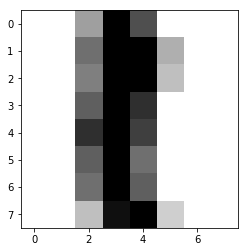

In [11]:
sample = X_test[150, :].reshape(1, -1)

print(u'Tahmin edilen değer: %d\n' % my_model.predict(sample)[0])

for index, value in enumerate(my_model.predict_proba(sample)[0]):
    print(u"Sonucun %d olma ihtimali: %%%.2f" % (index, float(value * 100.0)))

plt.imshow(sample.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')

Eğittiğimiz bu modeli artık bir dosyaya kaydetmemiz gerekiyor. Bunun için **joblib** adlı bir modül kullanacağız.

In [12]:
from sklearn.externals import joblib

joblib.dump(my_model, 'data/sayi_tahmin.pkl')

['sayi_tahmin.pkl']

Aynı modülü kullanarak modeli dosyadan çekip kullanmaya başlayabiliriz.

Tahmin edilen değer: 1

Sonucun 0 olma ihtimali: %0.06
Sonucun 1 olma ihtimali: %97.56
Sonucun 2 olma ihtimali: %0.27
Sonucun 3 olma ihtimali: %0.13
Sonucun 4 olma ihtimali: %0.12
Sonucun 5 olma ihtimali: %0.12
Sonucun 6 olma ihtimali: %0.12
Sonucun 7 olma ihtimali: %0.13
Sonucun 8 olma ihtimali: %1.40
Sonucun 9 olma ihtimali: %0.09


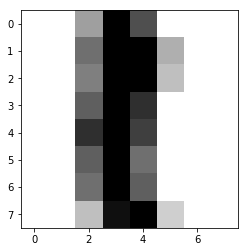

In [13]:
model = joblib.load('data/sayi_tahmin.pkl')


sample = X_test[150, :].reshape(1, -1)

print(u'Tahmin edilen değer: %d\n' % my_model.predict(sample)[0])

for index, value in enumerate(model.predict_proba(sample)[0]):
    print("Sonucun %d olma ihtimali: %%%.2f" % (index, float(value * 100.0)))

plt.imshow(sample.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')